In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
import logging

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

# 增量学习驱动的Transformer时间序列预测

## 基础知识

增量学习（Incremental Learning, IL）是一种使机器学习模型能够在持续获取新数据的同时，保留已学知识的策略。它不仅有助于模型在动态环境中保持性能稳定，还能显著减少重新训练所需的时间和计算资源。这种方法特别适合那些需要长期维护和更新的系统，如在线服务、自动驾驶系统和个性化推荐系统。

增量学习的核心策略：

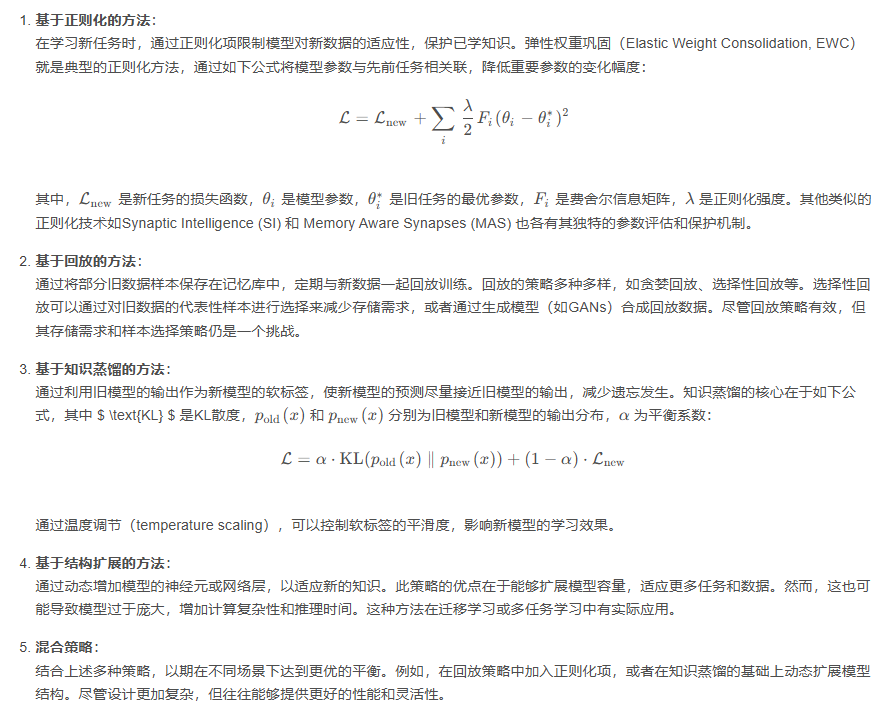

### 灾难性遗忘

在深度学习和人工智能领域中，“灾难性遗忘”（Catastrophic Forgetting）是指当神经网络在增量学习（Incremental Learning）或持续学习（Continual Learning）过程中遇到新任务时，往往会显著遗忘之前所学的任务知识。这种现象在需要模型长期积累知识的应用场景中尤为显著，如自动驾驶、机器人控制和人机交互等。

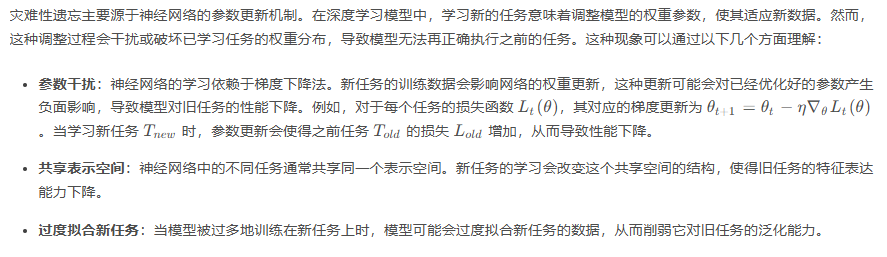

### 弹性巩固权重-EWC

弹性巩固权重（Elastic Weight Consolidation，简称EWC）是一种解决神经网络在增量学习（Incremental Learning）中遇到的“灾难性遗忘”问题的方法。该方法通过对模型的权重进行“巩固”来避免在学习新任务时对旧任务知识的遗忘。

在传统的增量学习中，神经网络会在学习新任务时逐步修改其网络参数。这可能导致网络遗忘已经学会的旧任务知识，尤其是在没有任何明确约束的情况下。这种现象被称为**灾难性遗忘**（Catastrophic Forgetting）。

EWC的核心思想是**保护那些对旧任务重要的权重**，从而减少这些权重在学习新任务时发生大幅度变化的可能性。通过在损失函数中引入一种正则化项来实现这一目标。

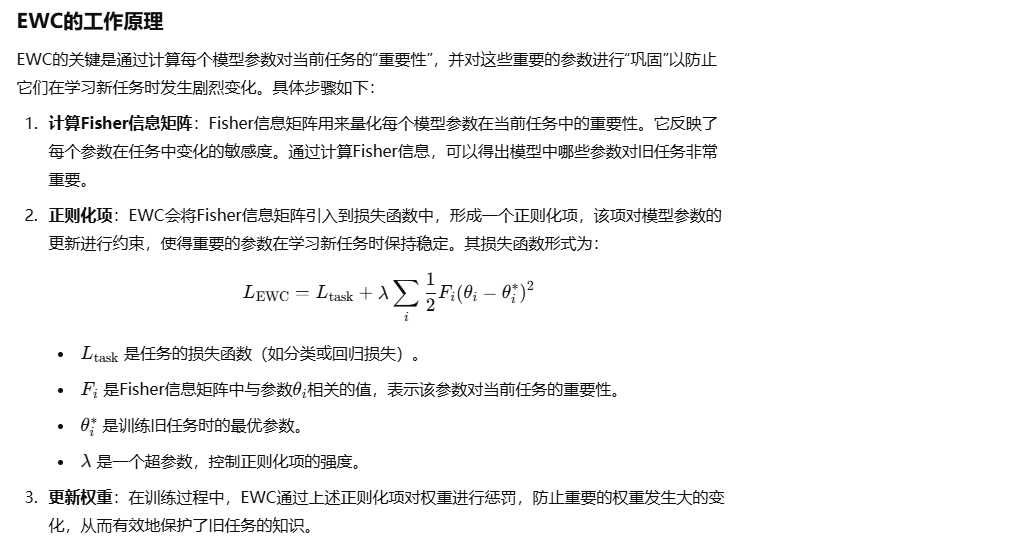

如何调节λ：
- 开始时使用较小的 λ，如 1e-3，并观察训练和验证损失：

- 如果发现新任务的损失下降很慢，可能是对旧任务的保护过强，可以稍微减小 λ。
- 如果发现灾难性遗忘（损失显著上升），增加 λ，以更强的惩罚力度保护旧任务的知识。

调优的建议：

- 早期训练阶段：开始时较小的 λ 值能使模型较快适应新任务。
- 随着训练进行：可以逐渐调整 λ，以保证旧任务知识的保护不干扰新任务的学习。

EWC的优势  
- 避免灾难性遗忘：通过巩固对旧任务重要的权重，EWC有效地减少了网络在学习新任务时遗忘旧任务的情况。
- 易于实现：EWC并不需要改变网络架构或进行复杂的操作，只需要计算Fisher信息并在损失函数中加入正则化项。
- 适用于多任务学习：EWC尤其适用于增量学习和多任务学习场景中，能够使得神经网络在多个任务之间共享知识，而不至于忘记之前学习的内容。

EWC的局限性  
- 计算开销：计算Fisher信息矩阵通常需要保存大量的模型参数和梯度信息，这对于大规模网络和大规模数据集可能造成较高的计算开销。
- 超参数选择：EWC中的正则化超参数λ需要根据具体任务进行调整，选择不当可能会导致模型在新任务上表现不佳。
- 仅适用于“可分离”任务：EWC假设不同任务之间的知识是可分离的，如果任务之间高度相关，EWC可能无法有效防止灾难性遗忘。

### Fisher信息矩阵

Fisher信息矩阵（Fisher Information Matrix）是一个用于衡量统计模型中参数不确定性和估计准确性的数学工具。在神经网络中，它被用来度量每个模型参数对损失函数的敏感度，帮助我们理解哪些参数对于任务的重要性较高。

在统计学中，Fisher信息是参数估计的精确度的度量，具体来说，它与模型参数的似然函数的曲率相关。Fisher信息矩阵 
F 定义为对数似然函数关于模型参数的二阶导数的期望值：

$$
F_{ij} = \mathbb{E} \left[ \frac{\partial \log p(x; \theta)}{\partial \theta_i} \cdot \frac{\partial \log p(x; \theta)}{\partial \theta_j} \right]$$


解释：  
- $ F_{ij} $：Fisher信息矩阵的元素，度量模型参数之间的相互敏感度。  
- $\mathbb{E} $：期望值运算符，表示对所有可能的数据样本取期望。  
- $ p(x; \theta) $：给定参数 \( \theta \) 的概率分布函数（似然函数）。  
- $ \theta_i $ 和$ \theta_j $：模型的参数。  
- $\frac{\partial \log p(x; \theta)}{\partial \theta_i} $：对数似然函数关于参数 $ \theta_i $ 的导数，表示模型输出对参数变化的敏感程度。

在神经网络中，Fisher信息矩阵用于**度量每个网络参数（权重）对当前任务的重要性**。EWC（弹性权重巩固）方法利用Fisher信息矩阵来帮助保护重要参数，防止它们在训练新任务时发生剧烈变化。

计算Fisher信息矩阵：通过对每个模型参数计算Fisher信息，可以得到参数在当前任务中的重要性程度。通常，Fisher信息矩阵是通过计算每个参数的梯度（对数似然的导数）并求其方差来近似得到的。

正则化项：EWC使用Fisher信息矩阵对模型参数进行正则化，防止它们在学习新任务时发生过度变化。具体地，EWC将Fisher信息矩阵引入损失函数的正则化项中，从而保护那些对旧任务非常重要的参数。

**在 Fisher 信息矩阵的计算中，不应该关闭自动求导(torch.no_grad())，因为计算 Fisher 信息矩阵的核心步骤是 反向传播求梯度。**

## 数据准备

In [2]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)

    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col]  # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [3]:
data_path = "../data/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [4]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [5]:
# 数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    # 归一化
    x_scaler = MinMaxScaler()  # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list])
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    # 测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    # 验证集
    if train_ratio != 1:
        valid = df.copy().iloc[int(df.shape[0]*train_ratio)
                        : int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
        valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
        valid_stamp = valid_stamp.transpose(1, 0)
        valid[x_feature_list] = x_scaler.transform(valid)
        xva = valid.values.astype('float32')
        yva = df.copy().iloc[int(df.shape[0]*train_ratio)
                      : int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
        yva[y_feature_list] = y_scaler.transform(yva)
        yva = yva.values.astype('float32')
        valid = [xva, yva, valid_stamp]
    else:
        valid = [np.array(0), np.array(0), np.array(0)]

    # 测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]

    return x_scaler, y_scaler, train, valid, test

In [6]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ['load', 'temp'],
    "y_feature_list": ['load', 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/Transformer'
}

# 函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(
    train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(
    valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(
    test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 2) y_train shape: (18412, 2) stamp_train shape: (18412, 4)
x_valid shape: (2631, 2) y_valid shape: (2631, 2) stamp_valid shape: (2631, 4)
x_test shape: (5261, 2) y_test shape: (5261, 2) stamp_test shape: (5261, 4)


In [7]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    stamp = data_list[2]  # 时间戳，不包含未来的时间

    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []

    for index in range(0, len(feature) - seq_len - pred_len + 1, sample_freq):
        # 起点
        s_begin = index
        # 终点(起点 + 回视窗口)
        s_end = s_begin + seq_len
        # (终点 - 先验序列窗口)
        r_begin = s_end - label_len
        # (终点 + 预测序列长度)
        r_end = r_begin + label_len + pred_len

        # 数据维度
        feat = feature[s_begin: s_end]
        tar = target[r_begin: r_end]
        X.append(np.array(feat))
        y.append(np.array(tar))

        # 时间维度
        xs = stamp[s_begin: s_end]
        ys = stamp[r_begin: r_end]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))

    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()

    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()

    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(
        X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)

    return X, y, X_stamp, y_stamp, data_loader

In [8]:
# 构造参数字典
params2 = {
    "seq_len": 60,
    "pred_len": 3,
    "label_len": 10,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(
    train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(
    valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(
    test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18350, 60, 2]),y_size: torch.Size([18350, 13, 2]),loader_len: 574
X_size: torch.Size([2569, 60, 2]),y_size: torch.Size([2569, 13, 2]),loader_len: 81
X_size: torch.Size([5199, 60, 2]),y_size: torch.Size([5199, 13, 2]),loader_len: 163


## 模型定义

In [9]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()
        
        # freq拆分
        number = re.findall('[0-9]', freq)
        number = 1 if len(number)==0 else int(''.join(number))
        string = re.findall('[a-z]', freq)[0]
        if string == 'h':
            hour_size = int(24 / number)
        elif string == 't':
            hour_size = 24
            minute_size = int(60 / number)
        elif string == 's':
            hour_size = 24
            minute_size = 60
            second_size = int(60 / number)
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        if freq == 's':
            self.second_embed = Embed(second_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        second_x = self.second_embed(x[:, :, 5]) if hasattr(
            self, 'second_embed') else 0.
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x + second_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# Transformer_EncDec类
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns
    
    
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x
    
    
# 自编码类
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
        
        
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
# Transformer模型
class Transformer(nn.Module):
    """
        embed: time features encoding, options:[timeF, fixed, learned]
        freq: 'freq for time features encoding, options:[s:secondly, 
            t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], 
            you can also use more detailed freq like 15min or 3h'
    """
    def __init__(self, seq_len, pred_len, label_len, output_attention, enc_in, d_model, dropout, factor, n_heads, d_ff, 
                e_layers, dec_in, d_layers, c_out, embed, freq):
        super(Transformer, self).__init__()
        self.pred_len = pred_len
        self.output_attention = output_attention
        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=output_attention), d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu'
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        FullAttention(True, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu',
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None)
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

## 模型训练（first）

In [10]:
def train(train_args, model_args):
    # 参数配置
    features = train_args['features']  # 模型预测模式
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len']  # 预测长度
    label_len = model_args['label_len']

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            # 将数据移至 device
            batch_x = batch_x.to(device)  # 会用到实际数据
            batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if features == 'MS' else 0
            outputs = outputs[:, -pred_len:, f_dim:]
            batch_y = batch_y[:, -pred_len:, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                # 将数据移至 device
                batch_x = batch_x.to(device)  # 会用到实际数据
                batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if features == 'MS' else 0
                outputs = outputs[:, -pred_len:, f_dim:]
                batch_y = batch_y[:, -pred_len:, f_dim:]
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_loss, val_loss):
        """
        绘制训练和验证损失曲线

        参数:
        - train_loss: 训练损失数组
        - val_loss: 验证损失数组
        """
        # 自动生成 epochs（假设train_loss和val_loss长度一致）
        epochs = np.arange(len(train_loss))

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white")

        # 创建图形并优化细节
        plt.figure(figsize=(10, 6))

        # 绘制训练和验证曲线
        plt.plot(epochs, train_loss, label='Training', color='#d62728', linewidth=2, marker='o', markersize=6)
        plt.plot(epochs, val_loss, label='Validation', color='#1f77b4', linewidth=2, marker='s', markersize=6)

        # 添加标题和标签
        plt.title('Training and Validation Loss', fontsize=18, fontweight='bold', color='black')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)

        # 添加图例
        plt.legend(fontsize=12, loc='upper right')

        # 启用横向网格线
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # 可选：修改左侧和底部边框的样式
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)

        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)

        plt.gca().tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 展示图形
        plt.show()

    if plots:
        plot_loss(train_losses, val_losses)

    return model

  5%|████▏                                                                              | 1/20 [01:26<27:23, 86.50s/it]

Epoch [1/20], Training Loss: 0.1393, Validation Loss: 0.0120
Validation loss decreased (inf --> 0.012030).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▏                                                                         | 2/20 [03:33<33:01, 110.06s/it]

Epoch [2/20], Training Loss: 0.0086, Validation Loss: 0.0019
Validation loss decreased (0.012030 --> 0.001909).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▎                                                                     | 3/20 [05:06<29:02, 102.49s/it]

Epoch [3/20], Training Loss: 0.0028, Validation Loss: 0.0024
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [06:30<25:25, 95.33s/it]

Epoch [4/20], Training Loss: 0.0020, Validation Loss: 0.0012
Validation loss decreased (0.001909 --> 0.001210).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [07:51<22:29, 89.99s/it]

Epoch [5/20], Training Loss: 0.0016, Validation Loss: 0.0021
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [09:08<19:58, 85.60s/it]

Epoch [6/20], Training Loss: 0.0013, Validation Loss: 0.0010
Validation loss decreased (0.001210 --> 0.000957).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [10:28<18:10, 83.91s/it]

Epoch [7/20], Training Loss: 0.0012, Validation Loss: 0.0011
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [11:47<16:25, 82.11s/it]

Epoch [8/20], Training Loss: 0.0011, Validation Loss: 0.0011
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [13:04<14:47, 80.73s/it]

Epoch [9/20], Training Loss: 0.0010, Validation Loss: 0.0021
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [14:25<13:26, 80.69s/it]

Epoch [10/20], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000957 --> 0.000784).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [15:45<12:03, 80.44s/it]

Epoch [11/20], Training Loss: 0.0008, Validation Loss: 0.0011
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [17:02<10:36, 79.57s/it]

Epoch [12/20], Training Loss: 0.0007, Validation Loss: 0.0009
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [18:19<09:11, 78.79s/it]

Epoch [13/20], Training Loss: 0.0007, Validation Loss: 0.0010
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [19:37<07:51, 78.57s/it]

Epoch [14/20], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000784 --> 0.000627).  Saving model ...
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [20:57<06:34, 78.81s/it]

Epoch [15/20], Training Loss: 0.0006, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [22:16<05:15, 78.94s/it]

Epoch [16/20], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000627 --> 0.000496).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [23:36<03:57, 79.21s/it]

Epoch [17/20], Training Loss: 0.0005, Validation Loss: 0.0006
EarlyStopping counter: 1 out of 5
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [24:53<02:37, 78.53s/it]

Epoch [18/20], Training Loss: 0.0005, Validation Loss: 0.0006
EarlyStopping counter: 2 out of 5
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [26:13<01:19, 79.06s/it]

Epoch [19/20], Training Loss: 0.0005, Validation Loss: 0.0006
EarlyStopping counter: 3 out of 5
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [27:32<00:00, 82.65s/it]

Epoch [20/20], Training Loss: 0.0004, Validation Loss: 0.0006
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0


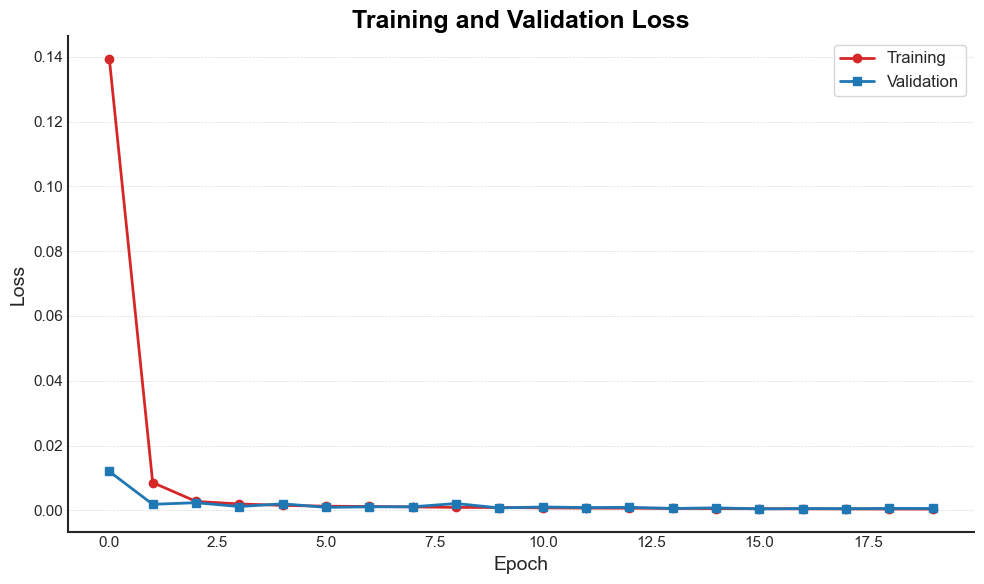

In [11]:
# 构造参数字典
params3 = {
    "train_args": {
        "features": 'M',
        "model_name": Transformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 5,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/Transformer_ewc",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3, 
        'label_len': 10,
        'output_attention': True,
        'embed': 'timeF', # 可选'timeF','fixed'和'learned'
        'freq': 'h',
        'd_model': 512,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 2
    },
}
model = train(**params3)

## 参数学习

In [22]:
class EWC():
    def __init__(self, ewc_args, model_args):
        model_name = ewc_args['model_name']  # 模型名称
        old_data_loader = ewc_args['old_data_loader']  # 旧数据集
        self.old_model_path = ewc_args['old_model_path']  # 模型保存路径
        self.criterion = ewc_args['criterion']  # 损失函数
        self.features = ewc_args['features']  
        self.device = ewc_args['device']  
        self.pred_len = model_args['pred_len']  # 预测长度
        self.label_len = model_args['label_len']

        # 检查模型路径
        os.makedirs(self.old_model_path, exist_ok=True)
        
        # 加载模型
        self.model = model_name(**model_args)
        state_dict = torch.load(os.path.join(self.old_model_path, "checkpoint.pth"), map_location=self.device)
        self.model.load_state_dict(state_dict)
        self.model = self.model.to(self.device)
        
        # 保存模型在旧任务上的最优参数值 θ*
        self.old_params = {name: param.clone().detach() for name, param in self.model.named_parameters()}
        torch.save(self.old_params, os.path.join(self.old_model_path, "params.pth"))
        
        # 计算Fisher信息矩阵
        self.fisher = self._compute_fisher(old_data_loader)
        logging.info("EWC Initialization Completed.")

    def _compute_fisher(self, data_loader):
        """ 计算模型在旧任务上的Fisher信息矩阵 """
        # 初始化Fisher信息矩阵
        fisher = {name: torch.zeros_like(param) for name, param in self.model.named_parameters()}

        self.model.eval()  # 设置模型为评估模式
        num_samples = len(data_loader)
        
        for batch_x, batch_y, batch_x_mark, batch_y_mark in data_loader:
            # 将数据移至设备
            batch_x = batch_x.to(self.device)
            batch_y = batch_y.to(self.device)
            batch_x_mark = batch_x_mark.to(self.device)
            batch_y_mark = batch_y_mark.to(self.device)

            # decoder输入构建
            dec_inp = torch.zeros_like(batch_y[:, -self.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :self.label_len, :], dec_inp], dim=1).float().to(self.device)
            
            # 模型预测与损失计算
            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if self.features == 'MS' else 0
            outputs = outputs[:, -self.pred_len:, f_dim:]
            batch_y = batch_y[:, -self.pred_len:, f_dim:]
            loss = self.criterion(outputs, batch_y)
            
            # 清空之前的梯度
            self.model.zero_grad()
            
            # 反向传播，计算梯度
            loss.backward()
            
            # 累加Fisher信息
            for name, param in self.model.named_parameters():
                if param.grad is not None:
                    fisher[name] += param.grad.data.clone() ** 2

        # Fisher 归一化处理
        for name in fisher.keys():
            fisher[name] /= num_samples

        # 保存Fisher信息矩阵
        torch.save(fisher, os.path.join(self.old_model_path, "fisher.pth"))
        logging.info(f"Fisher Information Computation Completed. Saved at {self.old_model_path}/fisher.pth")
        
        return fisher

    def __repr__(self):
        return (f"<EWC Object | Tracked Params: {len(self.old_params)} | "
                f"Fisher Matrix Keys: {list(self.fisher.keys())[:5]}...>")

In [23]:
# 构造参数字典
params4 = {
    "ewc_args": {
        "model_name": Transformer,
        "old_model_path": "../outputs/best_models/Transformer_ewc",
        "features": 'M',
        "device": 'cuda',
        "old_data_loader": train_loader,
        "criterion": nn.MSELoss(),
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3, 
        'label_len': 10,
        'output_attention': True,
        'embed': 'timeF', 
        'freq': 'h',
        'd_model': 512,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 2
    },
}
ewc = EWC(**params4)

In [24]:
print(ewc)

<EWC Object | Tracked Params: 94 | Fisher Matrix Keys: ['enc_embedding.value_embedding.tokenConv.weight', 'enc_embedding.temporal_embedding.embed.weight', 'encoder.attn_layers.0.attention.query_projection.weight', 'encoder.attn_layers.0.attention.query_projection.bias', 'encoder.attn_layers.0.attention.key_projection.weight']...>


## 增量训练

In [25]:
def il_train(train_args, model_args):
    # 参数配置
    features = train_args['features']  # 模型预测模式
    model_name = train_args['model_name']  # 旧模型名称
    ewc_name = train_args['ewc_name']  # 增量学习模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    old_model_path = train_args['old_model_path']  # 旧模型保存路径
    new_model_path = train_args['new_model_path']  # 旧模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'
    lambda_reg = train_args['lambda_reg']
    pred_len = model_args['pred_len']  # 预测长度
    label_len = model_args['label_len']

    # 检查可用device
    device = torch.device(device)

    # 创建旧模型
    model = model_name(**model_args)
    state_dict = torch.load(os.path.join(old_model_path, "checkpoint.pth"), map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)

    # 创建优化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 计算EWC正则化损失
    class EWCRegularization():
        def __init__(self, model_path, device):
            """
            初始化EWC正则化，加载Fisher信息矩阵和旧模型参数。
            """
            self.device = device
            self.fisher = torch.load(os.path.join(model_path, "fisher.pth"), map_location=device)
            self.old_params = torch.load(os.path.join(model_path, "params.pth"), map_location=device)
            print("加载Fisher信息和旧模型参数完成！")
    
        def regularization_loss(self, model):
            """
            计算EWC正则化损失。
            """
            loss = 0
            for name, param in model.named_parameters():
                if param.requires_grad:
                    loss += torch.sum(self.fisher[name] * (param - self.old_params[name])**2)
            return loss
    ewc_reg = EWCRegularization(old_model_path, device=device)

    # 设置保存模型路径
    if not os.path.exists(new_model_path):
        os.makedirs(new_model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            # 将数据移至 device
            batch_x = batch_x.to(device)  # 会用到实际数据
            batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if features == 'MS' else 0
            outputs = outputs[:, -pred_len:, f_dim:]
            batch_y = batch_y[:, -pred_len:, f_dim:]
            train_task_loss = criterion(outputs, batch_y)
            train_reg_loss = ewc_reg.regularization_loss(model)
            train_loss = train_task_loss + lambda_reg * train_reg_loss
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                # 将数据移至 device
                batch_x = batch_x.to(device)  # 会用到实际数据
                batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if features == 'MS' else 0
                outputs = outputs[:, -pred_len:, f_dim:]
                batch_y = batch_y[:, -pred_len:, f_dim:]
                val_task_loss = criterion(outputs, batch_y)
                val_reg_loss = ewc_reg.regularization_loss(model)
                val_loss = val_task_loss + lambda_reg * val_reg_loss
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, new_model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_loss, val_loss):
        """
        绘制训练和验证损失曲线

        参数:
        - train_loss: 训练损失数组
        - val_loss: 验证损失数组
        """
        # 自动生成 epochs（假设train_loss和val_loss长度一致）
        epochs = np.arange(len(train_loss))

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white")

        # 创建图形并优化细节
        plt.figure(figsize=(10, 6))

        # 绘制训练和验证曲线
        plt.plot(epochs, train_loss, label='Training', color='#d62728', linewidth=2, marker='o', markersize=6)
        plt.plot(epochs, val_loss, label='Validation', color='#1f77b4', linewidth=2, marker='s', markersize=6)

        # 添加标题和标签
        plt.title('Training and Validation Loss', fontsize=18, fontweight='bold', color='black')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)

        # 添加图例
        plt.legend(fontsize=12, loc='upper right')

        # 启用横向网格线
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # 可选：修改左侧和底部边框的样式
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)

        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)

        plt.gca().tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 展示图形
        plt.show()

    # 保存当前数据集的fisher信息阵和参数
    params = {
        "ewc_args": {
            "model_name": model_name,
            "old_model_path": new_model_path,
            "features": features,
            "device": device,
            "old_data_loader": train_loader,
            "criterion": criterion,
        },
        "model_args": model_args,
    }
    ewc_name(**params)
    print("保存Fisher信息和新模型参数完成！")

    if plots:
        plot_loss(train_losses, val_losses)

    return model

加载Fisher信息和旧模型参数完成！


  5%|████▏                                                                              | 1/20 [00:25<07:59, 25.22s/it]

Epoch [1/20], Training Loss: 0.0114, Validation Loss: 0.0022
Validation loss decreased (inf --> 0.002158).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:53<08:10, 27.24s/it]

Epoch [2/20], Training Loss: 0.0014, Validation Loss: 0.0010
Validation loss decreased (0.002158 --> 0.000981).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [01:35<09:30, 33.59s/it]

Epoch [3/20], Training Loss: 0.0010, Validation Loss: 0.0026
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [02:08<08:53, 33.37s/it]

Epoch [4/20], Training Loss: 0.0009, Validation Loss: 0.0024
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [02:39<08:11, 32.76s/it]

Epoch [5/20], Training Loss: 0.0008, Validation Loss: 0.0020
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [03:11<07:34, 32.48s/it]

Epoch [6/20], Training Loss: 0.0007, Validation Loss: 0.0008
Validation loss decreased (0.000981 --> 0.000819).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [03:44<07:05, 32.74s/it]

Epoch [7/20], Training Loss: 0.0007, Validation Loss: 0.0016
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [04:17<06:33, 32.76s/it]

Epoch [8/20], Training Loss: 0.0006, Validation Loss: 0.0010
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [04:58<06:28, 35.32s/it]

Epoch [9/20], Training Loss: 0.0006, Validation Loss: 0.0013
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [05:53<06:53, 41.31s/it]

Epoch [10/20], Training Loss: 0.0006, Validation Loss: 0.0007
Validation loss decreased (0.000819 --> 0.000685).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [06:40<06:26, 43.00s/it]

Epoch [11/20], Training Loss: 0.0006, Validation Loss: 0.0011
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [07:20<05:36, 42.12s/it]

Epoch [12/20], Training Loss: 0.0005, Validation Loss: 0.0008
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [07:58<04:47, 41.04s/it]

Epoch [13/20], Training Loss: 0.0005, Validation Loss: 0.0007
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [08:39<04:05, 40.86s/it]

Epoch [14/20], Training Loss: 0.0005, Validation Loss: 0.0007
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.00020610737385376348


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [09:24<04:01, 40.32s/it]

Epoch [15/20], Training Loss: 0.0004, Validation Loss: 0.0008
EarlyStopping counter: 5 out of 5
Early stopping!


保存Fisher信息和新模型参数完成！


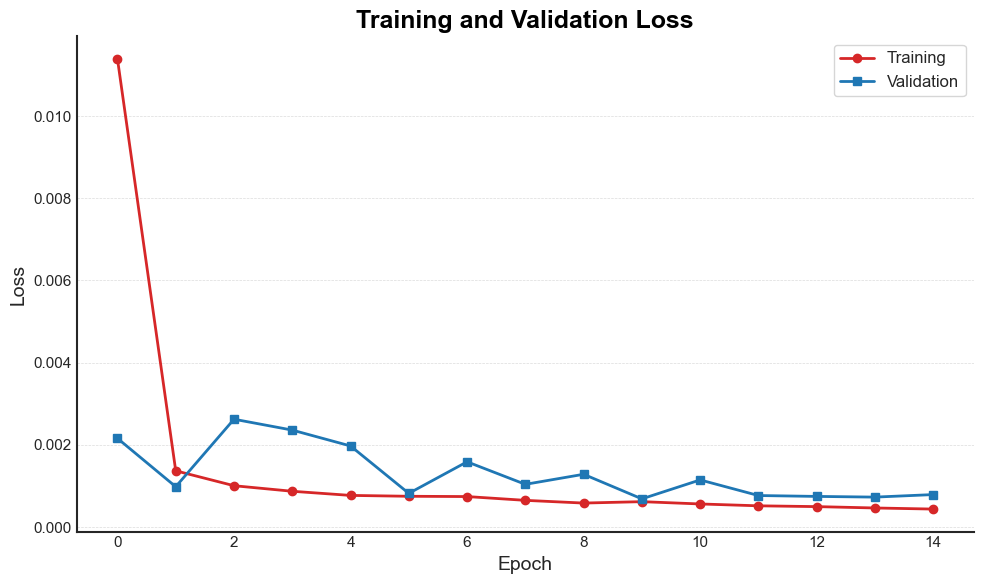

In [26]:
# 构造参数字典
params5 = {
    "train_args": {
        "features": 'M',
        "model_name": Transformer,
        "ewc_name": EWC,
        "train_loader": test_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 5,
        "lradj": 'cosine',
        "old_model_path": "../outputs/best_models/Transformer_ewc",
        "new_model_path": "../outputs/best_models/Transformer_ewc_new",
        "device": 'cuda',
        "lambda_reg": 1e-5,
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3, 
        'label_len': 10,
        'output_attention': True,
        'embed': 'timeF', 
        'freq': 'h',
        'd_model': 512,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 2
    },
}
model = il_train(**params5)

## 模型预测

In [5]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target']
    features = task_args['features']
    mode = task_args['mode'] # 可选'online'和'offline'
    time_col = predict_args['time_col']
    freq = predict_args['freq']
    model_name = predict_args['model_name']
    x_true = predict_args['x_true']
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    pred_len = model_args['pred_len']
    label_len = model_args['label_len']
    seq_len = model_args['seq_len']

    # 检查可用device
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)

    # 预测模式
    if mode == 'online':
        # 生成固定长度的时间范围
        x_true = loader(data_path=None, data=x_true, time_col=time_col)  # 原始数据
        x_true = x_true[columns]
        timedelta = x_true.index[-1] - x_true.index[-2]  # 时间差
        if label_len != 0:
            y_stamp = pd.date_range(start=x_true.index[-label_len],
                                    end=x_true.index[-label_len] +
                                    timedelta*(label_len+pred_len-1),
                                    freq=freq)
        else:
            y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1),
                                    end=x_true.index[-1] +
                                    timedelta*(label_len+pred_len),
                                    freq=freq)
        x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq)  # x时间戳数据
        x_stamp = x_stamp.transpose(1, 0)
        y_time = y_stamp
        y_stamp = time_features(y_stamp, freq=freq)  # y时间戳数据
        y_stamp = y_stamp.transpose(1, 0)
    
        # 转换类型
        x_true[columns] = x_scaler.transform(x_true)  # 归一化
        x_true = x_true.values.astype('float32')
        x_true = torch.as_tensor(x_true).unsqueeze(0).float()  # 转为张量
        x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
        y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
        # 关闭自动求导功能
        model.eval()  # 一定要有
        with torch.no_grad():
            x_true = x_true.to(device)
            x_stamp = x_stamp.to(device)
            y_stamp = y_stamp.to(device)
            # decoder输入
            B, _, _ = x_true.shape
            dec_inp = torch.zeros((B, pred_len + label_len, len(target))).float().to(device) # 占位符
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy()
            f_dim = -1 if features == 'MS' else 0
            y_pred = y_pred[:, -pred_len:, f_dim:]
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :])  # 反归一化
    
        # 输出为dataframe
        y_pred = pd.DataFrame(
            data=y_pred, index=y_time[-pred_len:], columns=target)
    # 离线模式
    else:
        # 构造数据集
        x_true_ = loader(data_path=None, data=x_true, time_col=time_col)  # 原始数据
        time_columns = x_true_.index  # 获取时间列
        x_true_ = x_true_.copy()[columns]
    
        # X时间编码
        x_stamp = pd.to_datetime(x_true_.index)
        x_stamp = time_features(x_stamp, freq=freq)
        x_stamp = x_stamp.transpose(1, 0)
    
        # y时间编码，包含未来的时间
        timedelta = x_true_.index[-1] - x_true_.index[-2]  # 时间差
        y_stamp = pd.date_range(start=x_true_.index[0],
                                end=x_true_.index[-1] +
                                timedelta*(pred_len),
                                freq=freq)
        y_stamp = time_features(y_stamp, freq=freq)
        y_stamp = y_stamp.transpose(1, 0)
    
        # X归一化
        x_true_[columns] = x_scaler.transform(x_true_)
        x_true_ = x_true_.values.astype('float32')
    
        # 生成预测张量
        X_true, X_stamp, Y_stamp = [], [], []
        sample_freq = 1
        for index in range(0, len(x_true) - seq_len + 1, sample_freq):
            # 起点
            s_begin = index
            # 终点(起点 + 回视窗口)
            s_end = s_begin + seq_len
            # (终点 - 先验序列窗口)
            r_begin = s_end - label_len
            # (终点 + 预测序列长度)
            r_end = r_begin + label_len + pred_len
    
            # 数据维度
            feat = x_true_[s_begin: s_end]
            X_true.append(np.array(feat))
    
            # 时间维度
            xs = x_stamp[s_begin: s_end]
            ys = y_stamp[r_begin: r_end]
            X_stamp.append(np.array(xs))
            Y_stamp.append(np.array(ys))
        X_true = torch.as_tensor(X_true).float()
        X_stamp = torch.as_tensor(X_stamp).float()
        Y_stamp = torch.as_tensor(Y_stamp).float()
    
        # 模型预测
        model.eval()
        with torch.no_grad():
            X_true = X_true.to(device)
            X_stamp = X_stamp.to(device)
            Y_stamp = Y_stamp.to(device)
    
            # decoder输入
            B, _, _ = X_true.shape
            dec_inp = torch.zeros(
                (B, pred_len + label_len, len(target))).float().to(device)
            y_pred = model(X_true, X_stamp, dec_inp, Y_stamp)
            y_pred = y_pred.cpu().detach().numpy()
            f_dim = -1 if features == 'MS' else 0
            y_pred = y_pred[:, -pred_len:, f_dim:]
    
        # y_pred的形状为 (batch_size, pred_len, feature_dim)
        batch_size, pred_len, feature_dim = y_pred.shape
        time_index = time_columns[seq_len-1:]
    
        # 初始化一个空的 DataFrame，每行是初始时间，每列是递增的预测步
        # 列名格式为 target_i，例如 target_1 表示预测步1，target_2 表示预测步2，依此类推
        columns = [f"{t}_{i+1}" for i in range(pred_len) for t in target]
        result_df = pd.DataFrame(index=time_index, columns=columns)
    
        # 填充 DataFrame，每一行是一个时间点的预测序列
        for i in range(batch_size):
            # 当前时间点的预测
            pred_data = y_scaler.inverse_transform(
                y_pred[i, :, :])  # 形状 (pred_len, feature_dim)
            pred_flattened = pred_data.flatten()  # 将预测结果展平
    
            # 将展平的预测步依次填入当前行
            result_df.iloc[i] = pred_flattened
    
        # 将原始数据与预测数据合并输出
        result_df = result_df.reset_index().rename(columns={'index': time_col})
        select_columns = [time_col] + target
        y_pred = pd.merge(x_true[select_columns], result_df, on=time_col, how='left')

    return y_pred

In [6]:
data_path = "../data/energy.csv"
ts_data = pd.read_csv(data_path)
ts_data['time'] = pd.to_datetime(ts_data['time'])
# 构造参数字典
params6 = {
    "task_args": {
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
        "mode": 'offline'
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": Transformer,
        "model_path": "../outputs/best_models/Transformer_ewc_new/checkpoint.pth",
        "x_true": ts_data,
        "scaler_path": '../outputs/scalers/Transformer',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3, 
        'label_len': 10,
        'output_attention': True,
        'embed': 'timeF', # 可选'timeF','fixed'和'learned'
        'freq': 'h',
        'd_model': 512,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 2
    },
}
y_pred = predict(**params6)

In [7]:
y_pred

,time,load,temp,load_1,temp_1,load_2,temp_2,load_3,temp_3
0,2012-01-01 00:00:00,2698.0,32.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 01:00:00,2558.0,32.67,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 02:00:00,2444.0,30.00,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 03:00:00,2402.0,31.00,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01 04:00:00,2403.0,32.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26299,2014-12-31 19:00:00,4012.0,18.00,3654.251465,15.314219,3655.98877,15.658456,3662.864502,15.850027
26300,2014-12-31 20:00:00,3856.0,16.67,3386.062256,13.487729,3386.216797,13.819921,3392.980225,13.993084
26301,2014-12-31 21:00:00,3671.0,17.00,3162.613281,13.989314,3162.801025,14.267256,3190.604248,14.544601
26302,2014-12-31 22:00:00,3499.0,15.33,3038.856445,13.125501,3061.53833,13.342542,3061.19458,13.46767


## 结果分析

In [8]:
# 获取最后一个预测结果
def last_prediction(prediction, pred_len, time_col, target):
    pre_target = [i+'_'+str(pred_len) for i in target]
    prediction_target = prediction[pre_target]
    time = prediction[[time_col]]
    # 向下平移数据
    prediction_shift = prediction_target.shift(pred_len)
    prediction_shift.columns = target
    # 对齐时间
    last_prediction = pd.concat([time, prediction_shift], axis=1)
    
    return last_prediction

In [16]:
# 获取最后一个预测结果
params7 = {
    "prediction": y_pred,
    "pred_len": 3,
    "time_col": 'time',
    "target": ['load', 'temp']
}
# y_pred = last_prediction(**params7)

### 评估指标

In [10]:
# 计算评估指标
def score(x1: pd.DataFrame,
          x2: pd.DataFrame,
          time_col: Union[str, None] = None,
          eval_metrics: str = 'rmse') -> float:
    """
    计算评估指标

    参数说明
    ----------
    x1 : {DataFrame} of shape (n_samples, n_features)
        输入数据
    x2 : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    eval_metrics : {str}
        评估指标值，可选'r2'和'rmse'

    返回值
    -------
    eval_value : {float}
        评估值
    """
    # 规范化数据
    x1 = x1.reset_index(drop=True)
    x2 = x2.reset_index(drop=True)

    # 选取时间列
    if time_col != None:
        no_time_cols = [i for i in x1.columns if i != time_col]
        x1[time_col] = pd.to_datetime(x1[time_col])
        x1_no_time = x1.loc[:, no_time_cols].values.astype('float32')
        x2[time_col] = pd.to_datetime(x2[time_col])
        x2_no_time = x2.loc[:, no_time_cols].values.astype('float32')
    else:
        x1_no_time = x1.values.astype('float32')
        x2_no_time = x2.values.astype('float32')

    # 缺失值删除
    x1_not_nan_index = np.where(~np.isnan(x1_no_time))[0]
    x2_not_nan_index = np.where(~np.isnan(x2_no_time))[0]
    not_nan_index = list(set(x1_not_nan_index) & set(x2_not_nan_index))
    x1_not_nan = x1_no_time[not_nan_index]
    x2_not_nan = x2_no_time[not_nan_index]

    # 计算评估指标
    if eval_metrics == 'r2':
        eval_value = r2_score(x1_not_nan, x2_not_nan)
    elif eval_metrics == 'rmse':
        eval_value = np.sqrt(mean_squared_error(x1_not_nan, x2_not_nan))

    return round(eval_value, 3)

In [14]:
# 评估指标
params8 = {
    "x1": ts_data,
    "x2": y_pred,
    "time_col": 'time',
    "eval_metrics": 'rmse'
}
score(**params8)

135.406

### 结果绘制

In [12]:
# 绘制子图
def __axs_plot(axs: ndarray,
               nums: int,
               x_in: DataFrame,
               x_out: DataFrame,
               time_col: Union[str, None],
               x_time: ndarray,
               y_label: str,
               threshold: float = 0.05):
    """
    绘制子图函数

    参数说明
    ----------
    axs : {numpy.ndarray}
        绘图示例
    nums : {int}
        绘制子图的个数
    x_in : {DataFrame} of shape (n_samples, n_features)
        实际值
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测值
    time_col : {str}
        时间列
    x_time : {numpy.ndarray}
        x轴的值
    y_label : {str}
        y轴标签
    threshold : {float}
        超限阈值比例

    返回值
    -------
    None
    """
    if nums > 1:
        for nn, ax in enumerate(axs):
            true = x_in.iloc[:, nn].values.astype("float")
            predict = x_out.iloc[:, nn].values.astype("float")
            # 选择数据，同一张子图需要绘制实际值和预测值曲线
            ax.plot(x_time, true)
            ax.plot(x_time, predict)
            # 绘制x轴标签
            if nn == nums - 1:
                ax.set_xlabel(time_col, fontsize=14)
            # 绘制y轴标签
            ax.set_ylabel('value', fontsize=14)
            # 绘制预测阈值带（安全范围的区间）
            ax.fill_between(x_time,
                            predict - predict * threshold,
                            predict + predict * threshold,
                            facecolor='red',
                            alpha=0.3)
            # 绘制图例
            rmse = round(score(pd.DataFrame(true), pd.DataFrame(predict)), 3)
            ax.legend([
                y_label[nn] + " 原始值", y_label[nn] + " 预测值" +
                " rmse: " + str(rmse),
                y_label[nn] + " 预警区间"
            ])
            # x轴文字旋转方向
            for xtick in ax.get_xticklabels():
                xtick.set_rotation(45)
    else:
        # 选择数据，同一张子图需要绘制实际值和预测值曲线
        if type(y_label) == list:
            y_label = y_label[0]
        true = x_in[y_label].values.astype("float").reshape((-1, ))
        predict = x_out[y_label].values.astype("float").reshape((-1, ))
        axs.plot(x_time, true)
        axs.plot(x_time, predict)
        # 绘制x轴标签
        axs.set_xlabel(time_col, fontsize=14)
        # 绘制y轴标签
        axs.set_ylabel('value', fontsize=14)
        # 绘制预测阈值带（安全范围的区间）
        axs.fill_between(x_time,
                         predict - predict * threshold,
                         predict + predict * threshold,
                         facecolor='red',
                         alpha=0.3)
        # 绘制图例
        rmse = round(score(pd.DataFrame(true), pd.DataFrame(predict)), 3)
        axs.legend([
            y_label + " 原始值", y_label + " 预测值" +
            " rmse: " + str(rmse),
            y_label + " 预警区间"
        ])
        # x轴文字旋转方向
        for xtick in axs.get_xticklabels():
            xtick.set_rotation(45)

    return 0


# 绘制曲线
def plot(x_in: DataFrame,
         x_out: DataFrame,
         time_col: Union[str, None] = None,
         plot_cols: Union[List[str], None] = None,
         threshold: float = 0.05) -> None:
    """
    绘制实际值和预测值曲线

    参数说明
    ----------
    x_in : {DataFrame} of shape (n_samples, n_features)
        输入数据
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    plot_cols : {Union[List[str], None]}
        需要绘制的特征列，如果为None，默认不绘制
    threshold : {float}
        预警阈值比例

    返回值
    -------
    None
    """
    # 选择数据
    if plot_cols == None:
        raise ValueError('请选择需要绘制的点，不能为空！')
    no_time_cols = [i for i in plot_cols if i != time_col]
    x_in[time_col] = pd.to_datetime(x_in[time_col])
    x_time = x_in[time_col]
    x_in = x_in[no_time_cols]
    x_out = x_out[no_time_cols]

    # 子图个数
    axs_nums = len(no_time_cols)

    # 分成左右两块画布
    if axs_nums > 1 and axs_nums % 2 == 0:
        # 左右子图个数
        axsLeft_nums = axsRight_nums = int(axs_nums / 2)
        # 创建画布，支持左右布局
        fig = plt.figure(constrained_layout=True,
                         figsize=(20, 4 * axsLeft_nums))
        subfigs = fig.subfigures(1, 2, wspace=0.07)
        # 左子图
        axsLeft = subfigs[0].subplots(axsLeft_nums, 1, sharex=True)
        __axs_plot(axsLeft, axsLeft_nums, x_in.iloc[:, :axsLeft_nums],
                   x_out.iloc[:, :axsLeft_nums], time_col, x_time,
                   no_time_cols[:axsLeft_nums], threshold)
        # 右子图
        axsRight = subfigs[1].subplots(axsRight_nums, 1, sharex=True)
        __axs_plot(axsRight, axsRight_nums, x_in.iloc[:, axsRight_nums:],
                   x_out.iloc[:, axsRight_nums:], time_col, x_time,
                   no_time_cols[axsRight_nums:], threshold)
        # 绘制表头
        fig.suptitle('预警曲线', fontsize=14)
    else:
        # 创建画布，支持单一画布
        if axs_nums == 1:
            no_time_cols = no_time_cols[0]
        fig = plt.figure(constrained_layout=True, figsize=(10, 4 * axs_nums))
        axs = fig.subplots(axs_nums, 1, sharex=True)
        __axs_plot(axs, axs_nums, x_in, x_out, time_col, x_time, no_time_cols,
                   threshold)
        # 绘制表头
        fig.suptitle('预警曲线', fontsize=14)
    plt.show()

    return 0

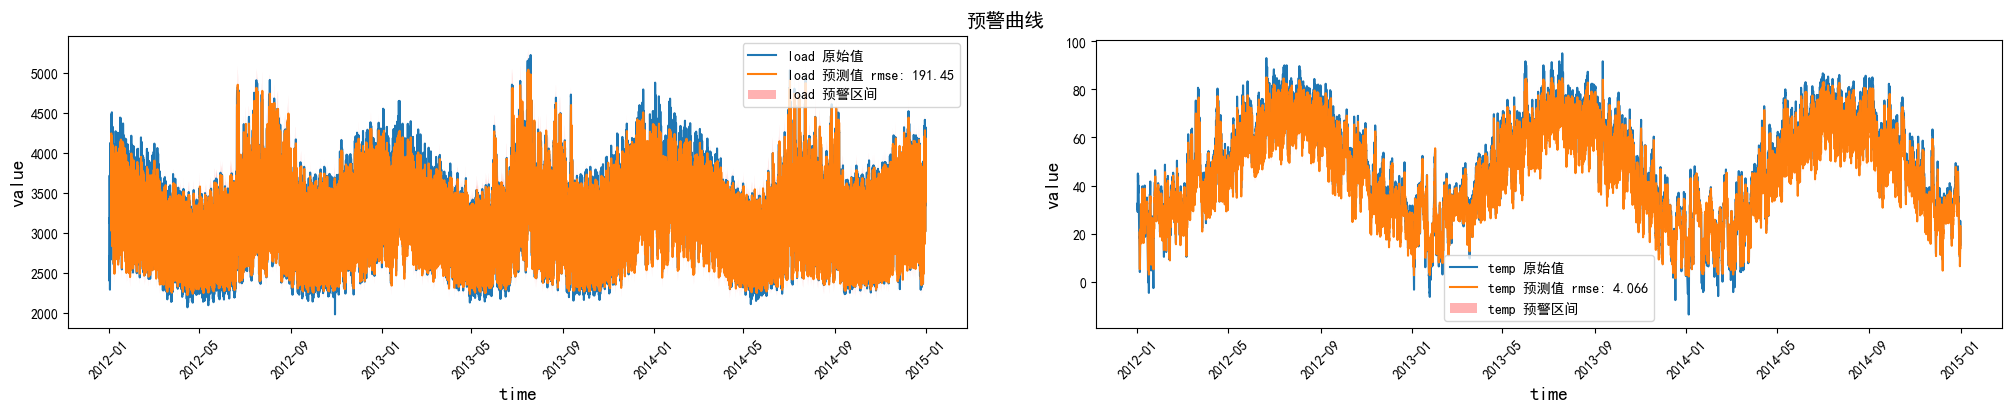

0

In [15]:
param9 = {
    'x_in': ts_data,
    'x_out': y_pred,
    'time_col': 'time',
    'plot_cols': ['load', 'temp'],
    'threshold': 0.05,
}
plot(**param9)